## Sentiment Analysis


In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
from scipy import stats
from pandas.plotting import scatter_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

plot_size = plt.rcParams["figure.figsize"]  

plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/julianjetz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, na_values=na_values)

In [4]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

In [5]:
ira_data.insert(4, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

In [6]:
ira_data.head(10)

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_ID,AD_CLICKS_PER_VIEW,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,...,AD_TARGETING_GENDER,AD_TARGETING_INTERESTS,AD_TARGETING_LANGUAGE,AD_TARGETING_LOCATION,AD_TARGETING_LOCATION_LIVING_IN,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET
0,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,1,0.016760,358.0,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,...,NaN,"News broadcasting, Political party, Breaking n...",English (US),NaN,United States,NaN,NaN,Instagram Feed,Instgogogo,52000000.0
1,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,2,0.002202,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,...,NaN,NaN,NaN,NaN,United States: Texas,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0
2,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,3,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,...,NaN,Cop Block or Black (Color),English (US),NaN,United States,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0
3,33.0,2016-04-19 07:49:45,NaT,4,0.002306,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,...,NaN,Cop Block,English (US),United States,NaN,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0
4,201.0,2016-06-15 03:39:52,NaT,5,0.006748,29786.0,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,...,NaN,Understanding racial segregation in the united...,NaN,NaN,United States: Georgia,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN
5,NaN,2016-05-12 04:06:17,NaT,6,NaN,NaN,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001744.pdf,NaN,13 - 44,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
6,54.0,2016-05-13 01:18:08,NaT,7,0.002307,23408.0,https://www.facebook.com/bat-240131319678646/,2016-q2/2016-05/P(1)0001746.pdf,2868.56 RUB,13 - 44,...,NaN,"Christ's Commission Fellowship, Jesus, Jesus D...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Conservative Christians. Pro-life/ gun/ police...,21000000.0
7,43.0,2016-03-11 05:04:42,NaT,8,0.004498,9559.0,https://www.instagram.com/black—america—today/,2016-q1/2016-03/P(1)0006379.pdf,2003.01 RUB,13 - 35,...,NaN,Hoodies or Trayvon Martin,English (UK)or English (US),United States,NaN,NaN,NaN,Instagram Feed,Trayvon Martin's lawyers wearing hoodies. Wear...,18000.0
8,13.0,2015-11-24 05:34:21,NaT,9,0.002669,4871.0,https://www.instagram.com/veterans_us/,2015-q4/2015-11/P(1)0001229.pdf,1052.89 RUB,18 - 65+,...,NaN,"Veterans Day, American Revolutionary War or Pa...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Edward was a combat engineer in Afghanistan wh...,3600000.0
9,11.0,2015-11-16 05:49:20,NaT,10,0.006769,1625.0,https://www.instagram.com/gov_spending/,2015-q4/2015-11/P(1)0001747.pdf,662.39 RUB,18 - 65+,...,NaN,"United States Senate, Election, Government or ...",English (US),United States,NaN,NaN,NaN,Instagram Feed,Unbelievable amount of the US government's was...,29000000.0


### Extract Hashtags
Extracting the Hashtags in case they are needed later

In [7]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", str(i))
        hashtags.append(ht)

    return hashtags

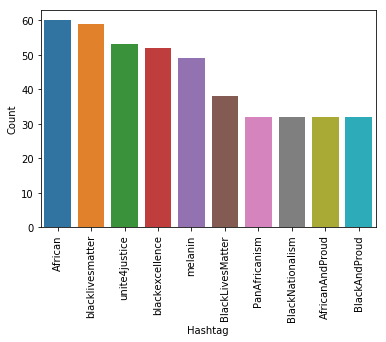

In [8]:
HT = hashtag_extract(ira_data['AD_TEXT'])
HT = sum(HT,[])

a = nltk.FreqDist(HT)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
#d.plot.bar()
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

### Add column with word count

In [9]:
ira_data['WORD_COUNT'] = ira_data['AD_TEXT'].apply(lambda x: len(str(x).split(" ")))
#ira_data = ira_data[ira_data['WORD_COUNT'] > 4]

### Remove hyperlinks

In [10]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

### Removal of stopwords

In [11]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_TEXT']
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop));

### Removal of words with less than 5 characters

In [12]:
# ira_data['AD_TEXT'] = ira_data['AD_TEXT'].apply(lambda x: ' '.join([w for w in str(x).split() if len(w)>4]))

### Stemming
removal of suffices, like “ing”, “ly”, “s”, etc. 

In [13]:
st = PorterStemmer()
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]));

### Lemmatization
converts the word into its root word

In [14]:
ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]));

### Lowercase

In [15]:
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace('[^\w\s]','')
ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].str.replace("[^a-zA-Z#]", " ")

In [16]:
ira_data['AD_CLEANED_TEXT'] = ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

### Common word removal
Removes the 10 most common words

In [17]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[:10]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

### Rare words removal
Removes the 10 most uncommon words

In [18]:
# freq = pd.Series(' '.join(ira_data['AD_CLEANED_TEXT']).split()).value_counts()[-10:]
# freq = list(freq.index)
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

In [19]:
# ira_data['AD_CLEANED_TEXT']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(x).split())

### Spelling correction
check for ur etc. before correction

In [20]:
# ira_data['AD_CLEANED_TEXT'].apply(lambda x: str(TextBlob(x).correct()))

In [21]:
duplicateDF = pd.concat(g for _, g in ira_data.groupby("AD_TEXT") if len(g) > 1).copy()
duplicateDF.sort_values(by=['AD_TEXT'], inplace=True)

### Total Duplicates

In [24]:
duplicateDF['AD_TEXT'].count()

1438

### Unique Duplicate-Pairs

In [22]:
duplicateDF['AD_TEXT'].nunique()

361

### Occurence of Duplicate-Pairs

In [53]:
duplicateDF['AD_TEXT'].value_counts().values

array([53, 23, 18, 16, 14, 14, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [25]:
duplicateDF[['AD_ID', 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_TARGETING_AGE', 'AD_TARGETING_GENDER', 'AD_TARGETING_INTERESTS', 'AD_TARGETING_LOCATION', 'AD_TARGETING_PLACEMENTS', 'AD_TEXT']].sample(30)

,AD_ID,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_TARGETING_AGE,AD_TARGETING_GENDER,AD_TARGETING_INTERESTS,AD_TARGETING_LOCATION,AD_TARGETING_PLACEMENTS,AD_TEXT
2296,2297,NaN,NaN,2016-10-26 06:12:51,16 - 65+,NaN,"Black Power, Racial equality, Social justice, ...",NaN,News Feed on desktop computers or Right column...,Your help is needed. This case is a classic ex...
2510,2511,429.0,9103.0,2016-10-20 07:25:03,18 - 65+,NaN,"Martin Luther King, Jr., African-American Civi...",NaN,News Feed on desktop computers or News Feed on...,This cop brutalized the child for taking a sho...
1345,1346,NaN,NaN,2016-05-05 03:27:06,21 - 65+,NaN,"Immigration, The Invaders or Politics",United States,News Feed on desktop computers or News Feed on...,Close the borders until it's too late. Like to...
3378,3381,20.0,488.0,2017-02-09 01:49:21,20 - 45,NaN,"Far-right politics, White nationalism, Interne...",NaN,"News Feed on desktop computers, News Feed on m...",Finely selected conservative memes that make t...
1636,1637,107.0,3072.0,2016-08-10 03:06:37,18 - 61,NaN,"Muslims Are Not Terrorists, Islam ism or Musli...",United States: Washington (+50 mi) District of...,News Feed on desktop computers or News Feed on...,"The safety, freedom, and dignity of all people..."
3011,3014,29.0,1339.0,2016-10-14 06:01:41,18 - 51,NaN,"Martin Luther King, Jr., God, Christian Church...",NaN,"News Feed on desktop computers, News Feed on m...","Our aim, to make Christianity real for Blacks!"
1214,1215,NaN,NaN,2015-12-10 01:31:18,18 - 65+,NaN,NaN,United States: Atlanta (+25 mi) Georgia; New O...,News Feed on desktop computers or News Feed on...,All Lives Matter! Join to stay in touch! Lates...
1434,1435,321.0,6785.0,2016-06-30 01:32:26,18 - 65+,NaN,NaN,United States: Baltimore (+25 mi) Maryland,News Feed on desktop computers or News Feed on...,"Last month, Edward M. Nero, the second to be t..."
2431,2432,NaN,NaN,2017-02-22 05:40:21,45 - 65+,NaN,"Bernie Sanders, Social democracy, Liberal Demo...",NaN,News Feed on desktop computers or News Feed on...,"New ideas, old values. Join!"
466,467,NaN,2.0,2016-09-22 05:01:05,18 - 65+,NaN,NaN,NaN,News Feed on desktop computers or News Feed on...,America has always been hinged on hard-working...


## Sentiment Analysis with TextBlob

In [26]:
ira_data['AD_TextBlob_POLARITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[0] )
ira_data['AD_TextBlob_SUBJECTIVITY']=ira_data['AD_CLEANED_TEXT'].apply(lambda x: TextBlob(x).sentiment[1] )

In [27]:
ira_data['AD_TextBlob_Sentiment'] = ira_data['AD_TextBlob_POLARITY'].apply(lambda x: 'positive' if x>0 else ('neutral' if x == 0 else 'negative'))

In [28]:
ira_data.head()

,AD_CLICKS,AD_CREATION_DATE,AD_END_DATE,AD_ID,AD_CLICKS_PER_VIEW,AD_IMPRESSIONS,AD_LANDING_PAGE,AD_PATH,AD_SPEND,AD_TARGETING_AGE,...,AD_TARGETING_LOCATION_RECENTLY_IN,AD_TARGETING_PEOPLE_WHO_MATCH,AD_TARGETING_PLACEMENTS,AD_TEXT,AD_POTENTIAL_TARGET,WORD_COUNT,AD_CLEANED_TEXT,AD_TextBlob_POLARITY,AD_TextBlob_SUBJECTIVITY,AD_TextBlob_Sentiment
0,6.0,2015-10-25 06:28:33,2015-10-27 23:59:00,1,0.016760,358.0,https://www.instagram.com/us_daily/,2015-q4/2015-10/P(1)0001736.pdf,161.23 RUB,18 - 51,...,NaN,NaN,Instagram Feed,Instgogogo,52000000.0,1,instgogogo,0.000000,0.000000,neutral
1,38.0,2015-10-20 10:36:20,2015-10-26 08:00:00,2,0.002202,17256.0,https://www.instagram.com/south_lone_star/,2015-q4/2015-10/P(1)0001738.pdf,1000.00 RUB,18 - 65+,...,NaN,NaN,Instagram Feed,You can go to hell or follow @south_lone_star ...,115000000.0,37,you can go to hell or follow south lone star i...,0.000000,0.000000,neutral
2,NaN,2015-10-26 10:45:51,2015-10-27 21:00:59,3,NaN,NaN,https://www.instagram.com/blackunionus/,2015-q4/2015-10/P(1)0001740.pdf,NaN,18 - 65+,...,NaN,NaN,Instagram Feed,Black lives matter because we see what's going...,17000000.0,43,black lives matter because we see whats going ...,-0.166667,0.433333,negative
3,33.0,2016-04-19 07:49:45,NaT,4,0.002306,14311.0,https://www.facebook.com/blacklivessss-9301580...,2016-q2/2016-04/P(1)0001742.pdf,7575.66 RUB,13 - 44,...,NaN,NaN,Instagram Feed,Don't Shoot is a community site where you can ...,490000.0,38,dont shoot is a community site where you can f...,-0.075000,0.487500,negative
4,201.0,2016-06-15 03:39:52,NaT,5,0.006748,29786.0,https://www.facebook.com/govspending-165176135...,2016-q2/2016-06/P(1)0000001.pdf,3714.15 RUB,18 - 65+,...,NaN,NaN,Instagram Feed,WHERE is your VOICE?,NaN,4,where is your voice,0.000000,0.000000,neutral


Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using TextBlob')

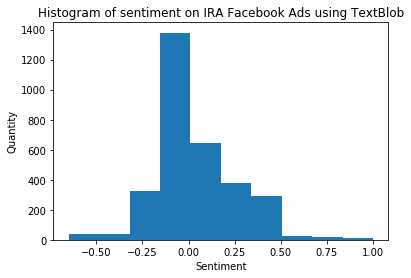

In [29]:
polarity=ira_data[ira_data['AD_TextBlob_SUBJECTIVITY'] < 0.8]
plt.hist(polarity['AD_TextBlob_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using TextBlob')

Text(0.5, 1.0, 'Histogram of subjectivity on IRA Facebook Ads')

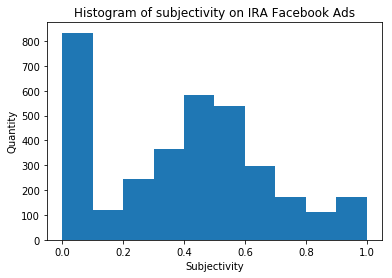

In [30]:
plt.hist(ira_data['AD_TextBlob_SUBJECTIVITY'])
plt.xlabel('Subjectivity')
plt.ylabel('Quantity')
plt.title('Histogram of subjectivity on IRA Facebook Ads')

## Sentiment Analysis with VADER

In [31]:
analyzer = sid()
ira_data['AD_VADER_POLARITY']=ira_data['AD_TEXT'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
ira_data['AD_VADER_Sentiment'] = ira_data['AD_VADER_POLARITY'].apply(lambda x: 'positive' if x>=0.5 else ('negative' if x <= -0.5 else 'neutral'))
ira_data['AD_VADER_Sentiment'].value_counts()

neutral     1363
positive    1196
negative     877
Name: AD_VADER_Sentiment, dtype: int64

Text(0.5, 1.0, 'Histogram of sentiment on IRA Facebook Ads using VADER')

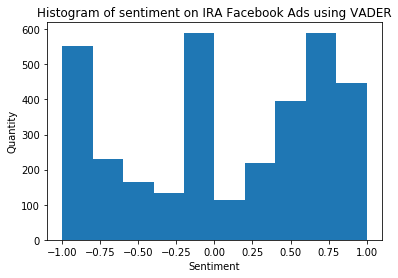

In [32]:
plt.hist(ira_data['AD_VADER_POLARITY'], histtype='bar')
plt.xlabel('Sentiment')
plt.ylabel('Quantity')
plt.title('Histogram of sentiment on IRA Facebook Ads using VADER')

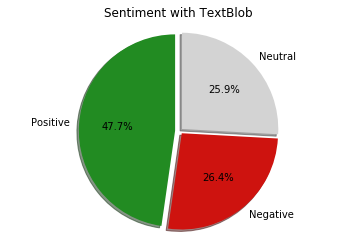

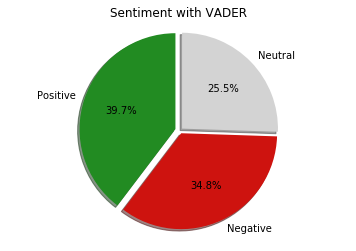

In [33]:
# TODO Change colour of pos and neg so that they are the same

fig1, ax1 = plt.subplots()
explode = (0.05, 0.03, 0.03)
labels='Positive', 'Negative', 'Neutral'
colors=['forestgreen', '#CE130F', 'lightgrey']
ax1.pie(ira_data['AD_TextBlob_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal') 
plt.title('Sentiment with TextBlob')
fig2, ax2 = plt.subplots()
ax2.pie(ira_data['AD_VADER_Sentiment'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax2.axis('equal') 
plt.title('Sentiment with VADER')

plt.show()

* * * * * * * * * *


### Most Common words

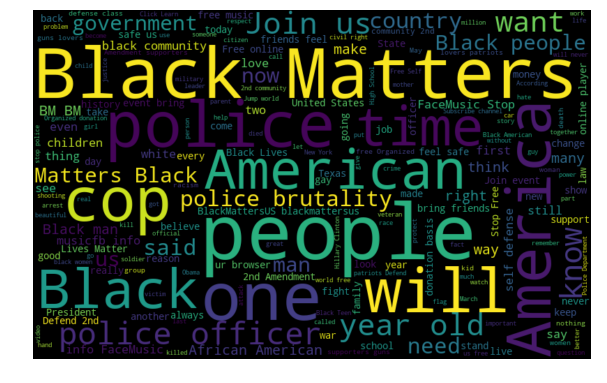

In [34]:
all_words = ' '.join([text for text in ira_data['AD_TEXT']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in positive Ads

In [35]:
ira_data = ira_data[ira_data['AD_TextBlob_Sentiment']==ira_data['AD_VADER_Sentiment']]

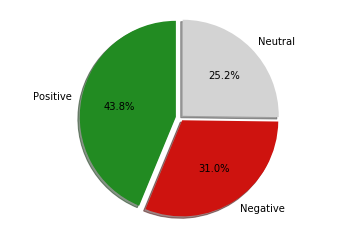

In [36]:
fig1, ax1 = plt.subplots()
explode = (0.05, 0.03, 0.03)
labels='Positive', 'Negative', 'Neutral'
colors=['forestgreen', '#CE130F', 'lightgrey']
ax1.pie(ira_data['AD_VADER_Sentiment'].value_counts(), labels=labels, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal') 
plt.show()

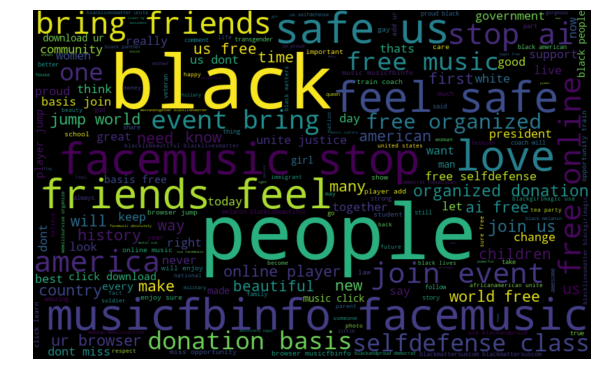

In [37]:
pos_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="positive"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Most Common words in negative Ads

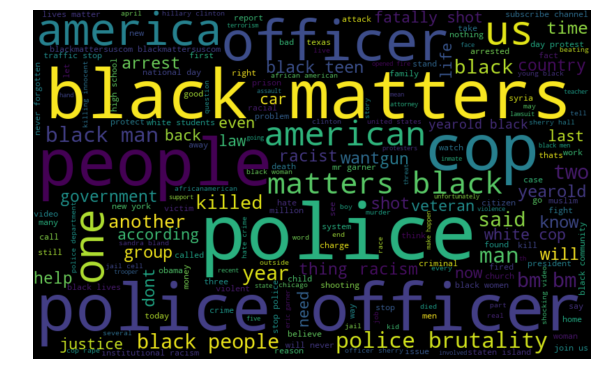

In [38]:
neg_words = ' '.join([text for text in ira_data['AD_CLEANED_TEXT'][ira_data['AD_VADER_Sentiment'] =="negative"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [59]:
pd.set_option('display.max_colwidth', -1)
ira_data[ira_data['AD_VADER_Sentiment'] == "negative"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
2403,"Justin Green, the Tulsa County Deputy has disclosed that Betty Shelby similarly used lethal force in 2010 when she was serving a warrant to a suspect. The Tulsa County Sheriff has revealed that Betty Shelby worked for them for four years until her joining the police service in 2011. It is on record that during Police Fatal Killing: Officer Betty Shelby Is Known For Using Excessive Force I BM BM",-0.150000,-0.8779
1170,Abused Killed Overworked Overpoliced Underappreciated Undervalued.... ...Tell and seek the truth,-0.200000,-0.7579
1236,"ANOTHER BLACK MAN MURDERED IN POLICE CUSTODY. THINGS HAVE BEEN VERY SILENT ON HIS BEHALF The 31-year-old black man died Feb. 20 at Fairfield Medical center after he had a °medical episode' at the jail when deputies were moving Ariel J. Clark from one cell to another. According to police reports; Ariel J. Clark, 31 was too combative with officers and was threatening to kill them during his arrest. On February 17, a motorist called 911 after interacting with Clark; reporting that Clark, who was driving his wife and two children from Buffulo to Texas, was threatening to kill him and his son. Clark's wife said that a man and his son began to argue with her husband, who had been acting wierd because he hadn't slept in five days. When the police arrived. Clark was arrested, taken to the Fairfield County Jail where he was placed in a restraint chair for his combative behavior. Three days after arriving in jail, Clark had some breathing difficulties and deputies started chest compression. But an hour later he was pronounced dead at a local hospital. An investigation has been opened after the death of a Fairfield County Jail inmate. Now the question is whether the jail's standard operating procedures were followed. We would like to see a true picture of what he looked like after ""fighting"" with the police. Also, we would like to see the picture of him when he arrived at hospital. For now the only thing we know is that another black man died in police custody.",-0.047368,-0.9903
2492,"America is far from stamping on racism problem. Unfortunately, the skin color can determine a whole range of variables in life.",-0.066667,-0.8481
226,"A `quiet and nice' 16-year-old girl ""who kept to herself"" is dead after an assault at Delaware high school. A teen girl died after she was assaulted at her Delaware high school, authorities said. The 10th grader, who has been identified as Amy Inita Joyner-Francis, wa TRAGIC: Teen Girl Beaten To Death In High School Bathroom I Black Matters Black Matters",-0.018485,-0.9736
2479,"Circulating jail videos show, Michael Sabbie begged for breath before dying as he was being manhandled by several police officers in his cell. Jail Videos Reveal Black Inmate Died After Assault By Officers I BM BM",-0.091667,-0.8126
2285,"On November 15, 2015, Jamar Clark. a 24-year-old black man, was fatally shot by two Minneapolis cops. According to witnesses. Jamar was handcuffed when he was shot. Killer cops involved in the shooting won't face discipline. Chief Janee Harteau recently said that an internal investigation found the officers were warranted in using deadly force in the death of the 24-year-old black man. It's been a year since he died. Justice still hasn't been served. Come out to honor the memory of Jamar on November 19. We won't stop until change is here! #blacklivesmatter Remember Jamar Clark",-0.106667,-0.8691
2079,"Now, when 25 years have passed since 1992 Riots, it's hard to imagine that photographers risked their lives to keep those moments for the future. Now, when 25 years have passed since 1992 Riots, it's hard to imagine that photographers risked their lives to keep those moments for the future. 1992 Riots Through Cold Lens Of Cameras I BlackMattersUS.com blackmattersus.com",-0.236667,-0.9260
1263,"What happened in Manchester is a tragedy beyond description that filled our hearts with inconsolable grief of pain and l

In [55]:
ira_data[ira_data['AD_VADER_Sentiment'] == "positive"][['AD_TEXT', 'AD_TextBlob_POLARITY', 'AD_VADER_POLARITY']].sample(25)

,AD_TEXT,AD_TextBlob_POLARITY,AD_VADER_POLARITY
3295,So lovely girl.,0.500000,0.6240
521,"Good morning, dear patriots! Today is 16th of July. The Apollo 11, the first U.S. lunar landing mission, is launched from Cape Canaveral, Florida, on this day in 1969. It was a great day in history! Americans are first and only who landed on the moon till today. We are the great nation! And we have to go forward with our head high!",0.422857,0.9466
753,"Show your support to all the victims of San Bernardino shooting by changing your profile picture here www.imsanbernardino.info Our thoughts and prayers go out to all the victims of the shooting. True, we Texans aren't really fond of California, but it's important to show we Americans are united against muslim aggressors. If you do realise we've got to stop playing with fire and send all the muslim invaders out of the country, change your profile pic! Show respect to the country you were born in, change the French flag on your profile picture to the American one here www.imsanbernardino.info #Texas #SanBernardino #IAm San Bernardino",0.190000,0.6034
1891,"Defend southern heritage! Follow instagram south united and get last news, history articles and even more! Click Learn more! South United Yoyoyoyoyo",0.250000,0.7753
356,"McKinney Police Officer Involved In Pool Party Incident Eric Casebolt, the McKinney, police officer who was caught on video pinning a teenage girl to the ground and pulling his gun on others at a pool party, has resigned Tuesday evening. The McKinney Police Department, Chief Of Police Greg Conley said that Casebolt's decision to leave was voluntary and that he would continue to collect a pension and benefits. Why are the police so aggressive? It's in every state around the country. The young girl at the pool party was treated horrible. Our society needs police, good police, people who will solve crimes but, unfortunately, today we need someone who will protect us from the police. At the same time, it is good that millions of regular people got a glimpse of what kind of policing minorities have endured for decades.",0.066667,0.7745
1878,"Is it a crime to be proud of being Black? Our women are of the most beauty and men of the most strength. American government and media try to suppress the idea of Blacks being equal, I'm not even talking about being better. We are better, we are tougher and we managed to pass through the centuries of slavery and oppression! That's why we must stay together, cause together we are power! United we stand, divided we fall! Join us! Black Pride ( @black Yoyoyoyoyoy",0.230000,0.9473
2883,Together we are a shining beacon of faithfulness! Join us and light your way to Jesus!,0.400000,0.6892
2073,"Congratulations, beautiful Queens! You can achieve any goals if you really believe in yourself. Just motivate yourself.",0.525000,0.8932
450,United We Stand! Welcome every patriot we can reach. Flag and news!,0.800000,0.7568
571,"Vatican Says Transgender Man Cannot Become A Godparent The Vatican has rejected a request by a transgender man in Spain to become a godparent, ruling that his sexual identity means he is incapable of carrying out the task. Alex Salinas was asked by his family to be godfather to his nephew, but the bishop of his local diocese on Spain's southern coast questioned his gender identity. Salinas was born a woman but has since undergone hormone therapy and has a male ID in Spain. He is now waiting for gender surgery. Bishop Rafael Zornoza Boy of Cadiz and Ceuta rejected the family's request to name Salinas as a godfather. Then, after a media storm, the bishop wrote to the Vatican for advice. Zornoza published the Vatican's reasoning for rejecting Salinas' wish. It said transsexual behavior ""reveals in a public way an attitude opposite to the moral imperative of solving the problem of sexual identity according to the truth of one's own sexuality."" The pope supported gays, but now for some reason the transman wasn't allowed to be a godf

In [41]:
ira_data['AD_VADER_Sentiment'].value_counts()

positive    828
neutral     587
negative    477
Name: AD_VADER_Sentiment, dtype: int64

In [42]:
ira_data['AD_TextBlob_Sentiment'].value_counts()

positive    828
neutral     587
negative    477
Name: AD_TextBlob_Sentiment, dtype: int64

In [43]:
corrdf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_VADER_POLARITY']]
corrdf = corrdf.dropna()
print(corrdf.shape[0])
corrdf = corrdf[(np.abs(stats.zscore(corrdf)) < 3).all(axis=1)]
print(corrdf.shape[0])



1377
1347


In [44]:
ira_data.shape[0]

1892

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.833986,0.544530,-0.193316
AD_IMPRESSIONS,0.833986,1.000000,0.110602,-0.169588
AD_CLICKS_PER_VIEW,0.544530,0.110602,1.000000,-0.132461
AD_VADER_POLARITY,-0.193316,-0.169588,-0.132461,1.000000


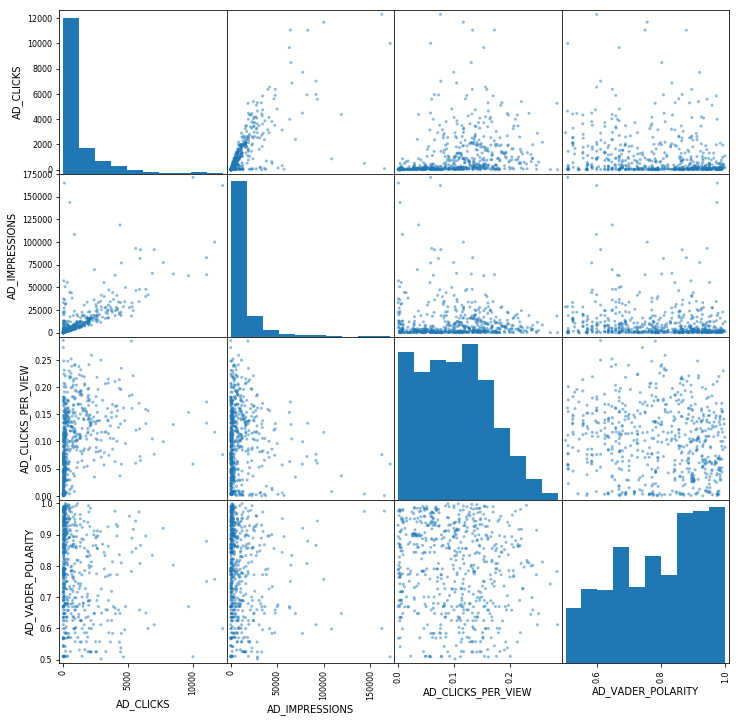

In [45]:
#positive ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] >= 0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.939546,0.295419,0.059241
AD_IMPRESSIONS,0.939546,1.000000,0.011754,0.078370
AD_CLICKS_PER_VIEW,0.295419,0.011754,1.000000,-0.064296
AD_VADER_POLARITY,0.059241,0.078370,-0.064296,1.000000


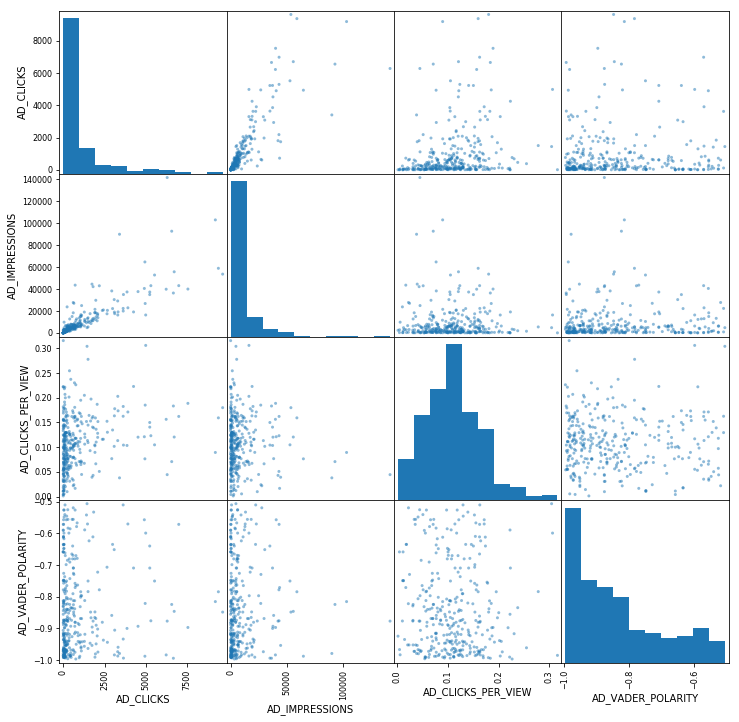

In [46]:
#negative ads corr
scatter_matrix(corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5], figsize=(12, 12))
corrdf[corrdf['AD_VADER_POLARITY'] <= -0.5].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.905009,0.406861,0.021229
AD_IMPRESSIONS,0.905009,1.000000,0.093447,0.056367
AD_CLICKS_PER_VIEW,0.406861,0.093447,1.000000,-0.066213
AD_VADER_POLARITY,0.021229,0.056367,-0.066213,1.000000


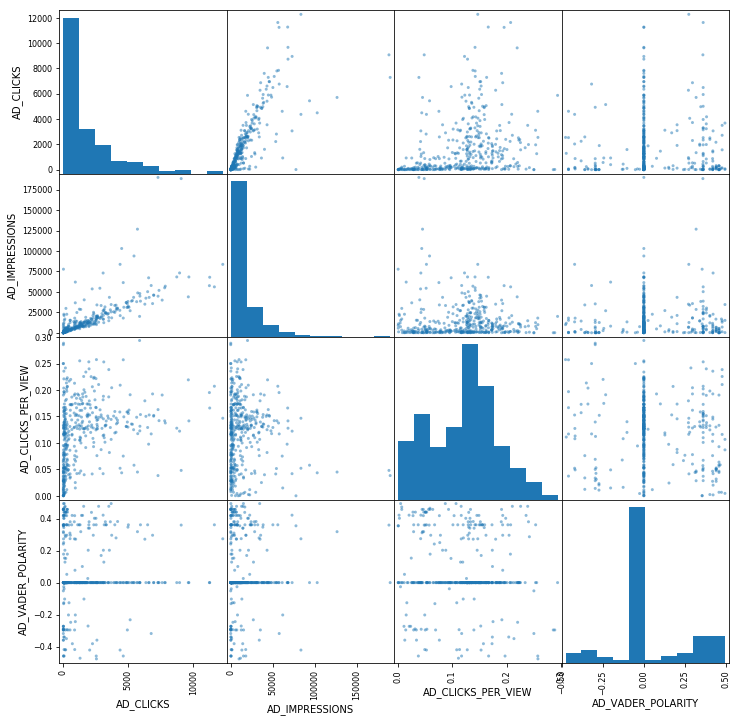

In [47]:
#neutral ads corr
scatter_matrix(corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)], figsize=(12, 12))
corrdf[(corrdf['AD_VADER_POLARITY'] > -0.5) & (corrdf['AD_VADER_POLARITY'] < 0.5)].corr(method ='spearman') 

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_VADER_POLARITY
AD_CLICKS,1.000000,0.881971,0.465277,-0.092494
AD_IMPRESSIONS,0.881971,1.000000,0.104378,-0.030706
AD_CLICKS_PER_VIEW,0.465277,0.104378,1.000000,-0.106330
AD_VADER_POLARITY,-0.092494,-0.030706,-0.106330,1.000000


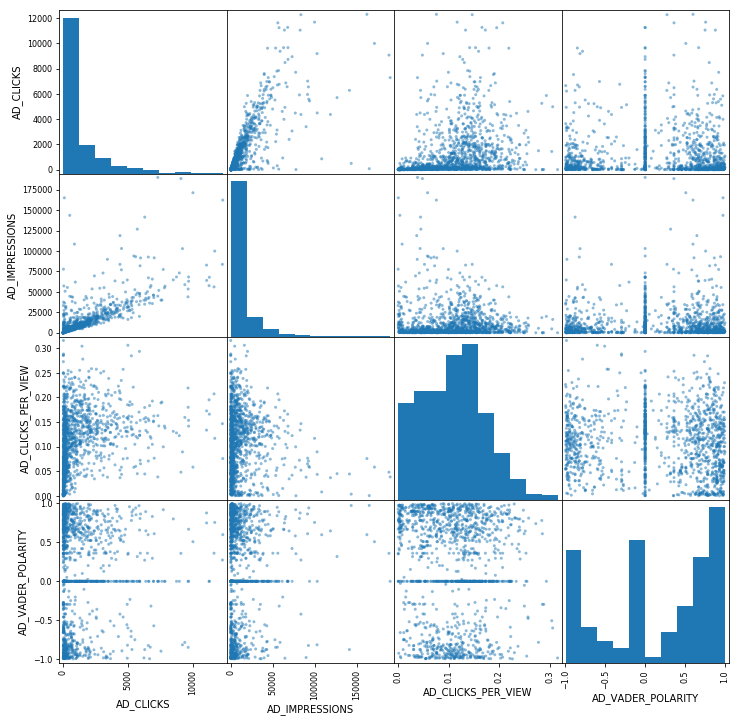

In [48]:
#all ads corr
scatter_matrix(corrdf, figsize=(12, 12))
corrdf.corr(method ='spearman') 

In [49]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentence = str(ira_data[ira_data['AD_ID']==725]['AD_TEXT'])
tokenized_sentence = nltk.word_tokenize(sentence)

sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sid.polarity_scores(word)['compound']) >= 0.05:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.05:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive:',pos_word_list)        
print('Neutral:',neu_word_list)    
print('Negative:',neg_word_list) 
score = sid.polarity_scores(sentence)
print('\nScores:', score)

Positive: ['strong', 'treat', 'like', 'committed', 'free', 'ready', 'commitment', 'liberty', 'wins', 'peacefully', 'ready', 'Invite', 'friends', 'Ready']
Neutral: ['724', 'Fellow', 'Texans', '!', 'It', "'s", 'time', 'to', 'say', 'a', 'to', 'the', 'establishment', 'robbers', '.', 'It', 'is', 'for', 'us', 'to', 'see', 'them', 'all', 'we', "'ve", 'been', 'building', 'for', 'decades', '.', 'For', 'centuries', '.', 'The', 'establishment', 'thinks', 'they', 'can', 'us', 'sheep', 'but', 'they', 'are', '.', 'We', 'wo', "n't", 'put', 'up', 'with', 'this', 'anymore', '.', 'The', 'corrupt', 'media', 'does', 'not', 'talk', 'about', 'the', 'crimes', 'by', 'Killary', 'Clinton', ',', 'neither', 'does', 'it', 'mention', 'the', 'emails', 'but', 'it', 'would', 'rather', 'keep', 'on', 'kicking', 'around', 'some', 'outdated', 'tapes', 'featuring', 'Trump', '.', 'Even', 'Republicans', 'are', 'now', 'offering', 'her', 'a', 'victory', 'by', 'renouncing', 'their', 'nominee', '.', 'What', 'is', 'this', 'if', '

In [50]:
sid.polarity_scores(str(ira_data[ira_data['AD_ID']==725]['AD_TEXT']))

{'neg': 0.158, 'neu': 0.643, 'pos': 0.199, 'compound': 0.899}

In [51]:
ira_data[['AD_ID', 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_TEXT']].sample(3) 

,AD_ID,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_TEXT
1990,1991,195.0,978.0,0.199387,"Congrats! This is amazing! You see, our people succeed in everything. Support each other and never give up."
1784,1785,6276.0,34943.0,0.179607,We call for disqualification and removal of Hillary Clinton from the presidential ballot as dynastic succession of the Clinton family in American politics breaches the core democratic principles laid out by our Founding Fathers. Sign the petition! We call for disqualification and removal of Hillary Clinton from the presidential ballot as dynastic succession of the Clinton family in American politics breaches the core democratic principles laid out by our Founding Fathers. We demand members of one family legislatively banned from holding the s... Disavow support for the Clinton political dynasty. Disqualify and remove Hillary Clinton from 2016 Presidential Ballot I We the People: Your Voice in Our Government Donald Trump America
2885,2886,4469.0,19055.0,0.234532,"Our Lord is alive and He will never die for He is the truth, the way and the life!"
